# Raster data

This notebook shows core raster data workflows using rasterio, rioxarray/xarray and rasterstats. Focus: IO, CRS/resampling, windows, plotting and simple zonal stats. 

In [1]:
# Cell 1: imports and versions (extended for practical examples)
import rasterio
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
from rasterio.plot import show
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import geopandas as gpd

print('rasterio', rasterio.__version__)
print('rioxarray', rxr.__version__)
print('xarray', xr.__version__)
print('python', sys.version.splitlines()[0])


rasterio 1.4.0
rioxarray 0.15.5
xarray 2024.7.0
python 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]


## Read raster (rasterio)
Open a GeoTIFF and inspect CRS, shape and metadata.

In [2]:
# Use the population raster added to data/population
path = 'data/population/example_las_palmas_population.tif'

with rasterio.open(path) as src:
    print('crs:', src.crs)
    print('size (w,h):', src.width, src.height)
    print('bands:', src.count)
    print('dtype:', src.dtypes)
    print('bounds:', src.bounds)
    # read first band as numpy array
    arr = src.read(1)
    print('array shape:', arr.shape)
    print('min/max:', float(arr.min()), float(arr.max()))


RasterioIOError: data/population/example_las_palmas_population.tif: No such file or directory

## Using rioxarray for multi-band or time data
rioxarray wraps xarray to add CRS and rio-specific methods. Useful for stacks and time-series.

rioxarray DataArray: <xarray.DataArray (band: 1, y: 164, x: 241)> Size: 158kB
[39524 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 7.575 7.576 7.577 7.578 ... 7.774 7.775 7.776
  * y            (y) float64 1kB 45.14 45.14 45.14 45.14 ... 45.01 45.01 45.01
    spatial_ref  int64 8B 0
Attributes:
    units:          people/km^2
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      population_per_sqkm


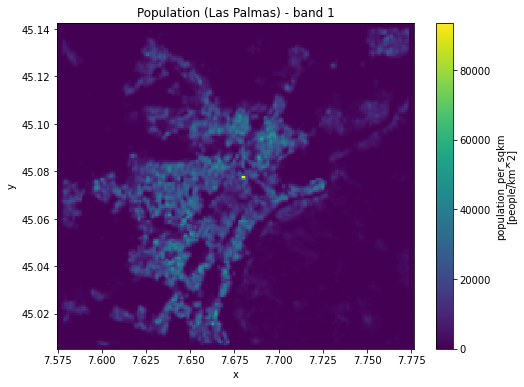

In [ ]:
# rioxarray example: open as xarray DataArray with CRS
rda = rxr.open_rasterio(path, masked=True)
print('rioxarray DataArray:', rda)
# show basic plot (first band)
rda.sel(band=1).plot(figsize=(8,6), cmap='viridis')
plt.title('Population (Las Palmas) - band 1')
plt.show()


## Reprojection and resampling (rasterio)
Show how to reproject a raster to a target CRS and resample. Keep example concise and point to rasterio docs for details.

In [ ]:
# Reproject raster to EPSG:3857 (template)
src_crs = None
with rasterio.open(path) as src:
    src_crs = src.crs
    transform, width, height = calculate_default_transform(src.crs, 'EPSG:3857', src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({'crs': 'EPSG:3857', 'transform': transform, 'width': width, 'height': height})
    # reproject into memory for demonstration (use output file for persistent storage)
    dest = np.empty((src.count, height, width), dtype=src.meta['dtype'])
    for i in range(1, src.count+1):
        reproject(
            source=rasterio.band(src, i),
            destination=dest[i-1],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs='EPSG:3857',
            resampling=Resampling.nearest
        )
print('reprojected array shape:', dest.shape)


reprojected array shape: (1, 202, 210)


## Why resampling matters (and why the choice is crucial)

Resampling is the operation of changing a raster's resolution or grid alignment (during reprojection, aggregation or up/down‑scaling). It is not just a technical step — it directly affects the values, patterns and interpretation of your data.

Key points and trade‑offs
- Downsampling (reducing resolution) can remove detail and smooth extremes; use aggregate methods (sum, mean) when you need to preserve totals or averaged quantities.
- Upsampling (increasing resolution) creates interpolated values that do not add new information; choose interpolation (bilinear, cubic) when you want smoothness, nearest for categorical data to avoid spurious classes.
- Preserve conservation: for areal quantities (population, mass) use sum or area‑weighted aggregation so totals remain meaningful after resampling.
- Maintain categorical integrity: for land‑use or class maps, use nearest or mode to avoid introducing mixed classes.
- Watch nodata handling and masks: improper treatment can bias statistics and produce holes or false values.
- Coordinate alignment matters: reprojecting without consistent grid/transform can shift pixels; consider calculating a target transform and using explicit resampling to control alignment.
- Document your choice: record the resampling method, rationale and any post‑processing (e.g., renormalization) so downstream users understand limitations.

In short: pick a resampling method that matches the data semantics (continuous vs categorical vs extensive totals) and the analysis objective — this prevents accidental loss or distortion of information.

## Rasterio resampling methods and when to use them

Rasterio exposes resampling methods via `rasterio.warp.Resampling`. Choice depends on data semantics (categorical vs continuous vs extensive), required smoothness, and conservation of totals.

- `nearest`  
    - Description: nearest-neighbour (no interpolation).  
    - Use when: categorical/class maps (land use, labels) or when you must avoid creating new intermediate values.

- `bilinear`  
    - Description: linear interpolation using 4 neighbouring pixels.  
    - Use when: continuous measurements (e.g., elevation, reflectance) where smoother results are wanted and modest interpolation is acceptable.

- `cubic` / `cubic_spline`  
    - Description: higher-order interpolation for smoother results than bilinear.  
    - Use when: continuous data where visual quality matters and some overshoot is acceptable (e.g., imagery).

- `lanczos`  
    - Description: windowed sinc interpolation (high-quality, expensive).  
    - Use when: high-fidelity resampling of continuous data (photographic imagery), prefer for downsampling where aliasing matters.

- `average`  
    - Description: pixel value = average of all source pixels contributing to a destination pixel.  
    - Use when: downsampling continuous density/ratio data where you want a mean value per output pixel.

- `sum`  
    - Description: sum of source pixels contributing to the output pixel.  
    - Use when: extensive quantities (population counts, total mass) where totals must be conserved during aggregation.

- `mode`  
    - Description: most common value among source pixels.  
    - Use when: categorical maps where majority class within the output footprint is desired.

- `max`, `min`, `med` (median), `gauss`  
    - Description: statistical/filters (maximum, minimum, median, gaussian smoothing).  
    - Use when: you want filtering effects (remove outliers, smooth noise) or compute envelope-like aggregations.

Practical notes
- Preserve conservation: for area‑integrated quantities (population, totals) use `sum` or explicit area‑weighted aggregation so totals remain meaningful. For densities (e.g., people/km²), use `average` or rescale after aggregation.  
- Categorical integrity: use `nearest` or `mode` to avoid creating mixed/interpolated classes.  
- Performance: higher-order methods (`cubic`, `lanczos`) are more CPU/memory intensive.  
- Nodata handling: ensure nodata and masks are respected during resampling to avoid bias or artifacts.  
- Always document the chosen resampling method and rationale for reproducibility.

## Zonal statistics (rasterstats)
Compute mean/median of raster values per polygon. Use `rasterstats.zonal_stats`.

**Zonal statistics — step-by-step**

Steps:

1. Build a regular grid of polygons covering the raster extent (so polygons match the raster area).
2. Plot the raster with the grid overlay to visually inspect cell alignment.
3. Run `rasterstats.zonal_stats` on the grid polygons to compute mean/sum/count of population per cell.
4. Attach statistics to the grid GeoDataFrame and display the full table.
5. Visualize the aggregated mean as a choropleth to review spatial patterns.

Run the following cells in order for reproducible results.

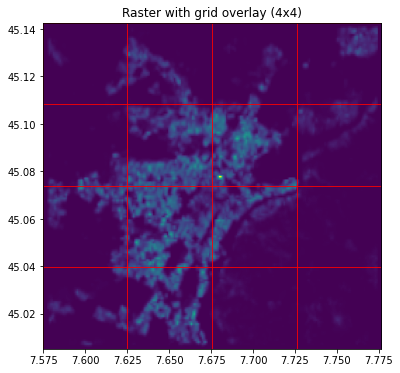

Running zonal_stats on grid...

Grid zonal statistics (all cells):


,id,pop_mean,pop_sum,pop_count
0,0,1801.107317,4.430724e+06,2460
1,1,4040.508130,9.939650e+06,2460
2,2,1497.559959,3.683998e+06,2460
3,3,682.444970,1.678815e+06,2460
4,4,8636.415834,2.159968e+07,2501
5,5,14501.983207,3.626946e+07,2501
6,6,12366.456617,3.092851e+07,2501
7,7,2656.612355,6.644188e+06,2501
8,8,701.077744,1.724651e+06,2460
9,9,6066.608943,1.492386e+07,2460


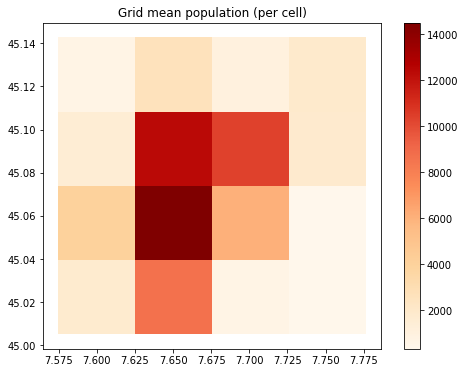

In [ ]:
# Stepwise zonal statistics using grid derived from raster extent
from shapely.geometry import box
import geopandas as gpd
import pandas as pd

# 1) Read raster bounds and build a grid (nrows x ncols)
with rasterio.open(path) as src:
    bounds = src.bounds
    raster_crs = src.crs
    nodata = src.nodata

nrows, ncols = 4, 4
xmin, ymin, xmax, ymax = bounds.left, bounds.bottom, bounds.right, bounds.top
x_step = (xmax - xmin) / ncols
y_step = (ymax - ymin) / nrows
grid_polys = []
ids = []
idx = 0
for i in range(ncols):
    for j in range(nrows):
        x0 = xmin + i * x_step
        x1 = x0 + x_step
        y0 = ymin + j * y_step
        y1 = y0 + y_step
        grid_polys.append(box(x0, y0, x1, y1))
        ids.append(idx)
        idx += 1
grid_gdf = gpd.GeoDataFrame({'id': ids}, geometry=grid_polys, crs=raster_crs)

# 2) Plot raster with grid overlay to inspect alignment
with rasterio.open(path) as src:
    fig, ax = plt.subplots(figsize=(8,6))
    show(src.read(1), transform=src.transform, cmap='viridis', ax=ax)
    grid_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.6)
    ax.set_title('Raster with grid overlay (4x4)')
    plt.show()

# 3) Compute zonal statistics for each grid cell
print('Running zonal_stats on grid...')
stats = zonal_stats(grid_gdf, path, stats=['mean','sum','count'], nodata=nodata)

# 4) Attach statistics to GeoDataFrame and show table
grid_gdf['pop_mean'] = [s.get('mean') for s in stats]
grid_gdf['pop_sum'] = [s.get('sum') for s in stats]
grid_gdf['pop_count'] = [s.get('count') for s in stats]

# Prepare and display full table sorted by id (use display once to avoid duplicate output)
from IPython.display import display
df = grid_gdf[['id','pop_mean','pop_sum','pop_count']].sort_values('id').reset_index(drop=True)
print('\nGrid zonal statistics (all cells):')
display(df)

# 5) Visualize the mean as a choropleth
fig, ax = plt.subplots(figsize=(8,6))
grid_gdf.plot(column='pop_mean', cmap='OrRd', legend=True, ax=ax)
ax.set_title('Grid mean population (per cell)')
plt.show()


### Notebook flow summary

This notebook demonstrates a concise raster data workflow:
1. Read a GeoTIFF with rasterio and inspect metadata.
2. Use rioxarray/xarray for convenient band-aware plotting.
3. Reproject/resample a raster (example to EPSG:3857).
4. Build a regular grid covering the raster extent and visually inspect alignment.
5. Run `rasterstats.zonal_stats` to compute aggregated values per grid cell and attach results to a GeoDataFrame.
6. Visualize results (choropleth) and explore value distributions (histogram).

Run the cells sequentially. If you want a finer grid, change `nrows`/`ncols` in the zonal-stats cell.